In [1]:
import pygplates
import pygmt
import pandas as pd
import numpy as np
import geopandas as gpd

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(pygplates.__version__)

from gprm import ReconstructionModel, SubductionConvergence, PointDistributionOnSphere
from gprm.datasets import Reconstructions, Seafloor
from gprm.utils.create_gpml import gdf2gpml, gpml2gdf


0.36.0


In [2]:
LIPs = gdf2gpml(Seafloor.LargeIgneousProvinces())


LIP_centroids = []
for feature in LIPs:
    if feature.get_geometry():
        LIP_centroid = pygplates.Feature()
        LIP_centroid.set_geometry(feature.get_geometry().get_interior_centroid())
        LIP_centroid.set_reconstruction_plate_id(feature.get_reconstruction_plate_id())
        LIP_centroid.set_valid_time(feature.get_valid_time()[0], feature.get_valid_time()[1])
        LIP_centroid.set_name(feature.get_name())
        LIP_centroids.append(LIP_centroid)

LIP_centroids = pygplates.FeatureCollection(LIP_centroids)



def reconstructed_volcanics(reconstruction_model, reconstruction_time, time_range, anchor_plate_id=0):

    time_min = reconstruction_time-time_range
    time_max = reconstruction_time+time_range

    LIP_centroids = []
    for feature in LIPs:
        if feature.get_valid_time()[0]>time_min and feature.get_valid_time()[0]<time_max:
            if feature.get_geometry():
                #print(feature.get_geometry().get_boundary_centroid())
                LIP_centroid = pygplates.Feature()
                LIP_centroid.set_geometry(feature.get_geometry().get_boundary_centroid())
                LIP_centroid.set_reconstruction_plate_id(feature.get_reconstruction_plate_id())
                LIP_centroid.set_valid_time(time_max, time_min)
                LIP_centroid.set_name(feature.get_name())
                LIP_centroids.append(LIP_centroid)

    reconstructed_centroids = reconstruction_model.reconstruct(pygplates.FeatureCollection(LIP_centroids),
                                                               reconstruction_time)

    return gpml2gdf(reconstructed_centroids)          

In [3]:
HS = pd.read_excel('../data/1810-1_JacksonD_et_al_2020.xlsx', sheet_name='Table S1', skiprows=1, header=None)

header_rows = HS.iloc[0:4,:].replace({np.nan: ''})
header_rows = header_rows.astype('str')
header_str = [' '.join(header_rows.iloc[:,i].tolist()) for i in header_rows.columns]
header_str = [s.strip() for s in header_str]

HS.columns = header_str

HS = HS.iloc[5:,:]

HS = HS.replace({'Tasmandit': 'Tasmantid'}, regex=True)

HS = HS.dropna(subset=['Hotspot Longitude (at surface) Vertical plume'])


grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


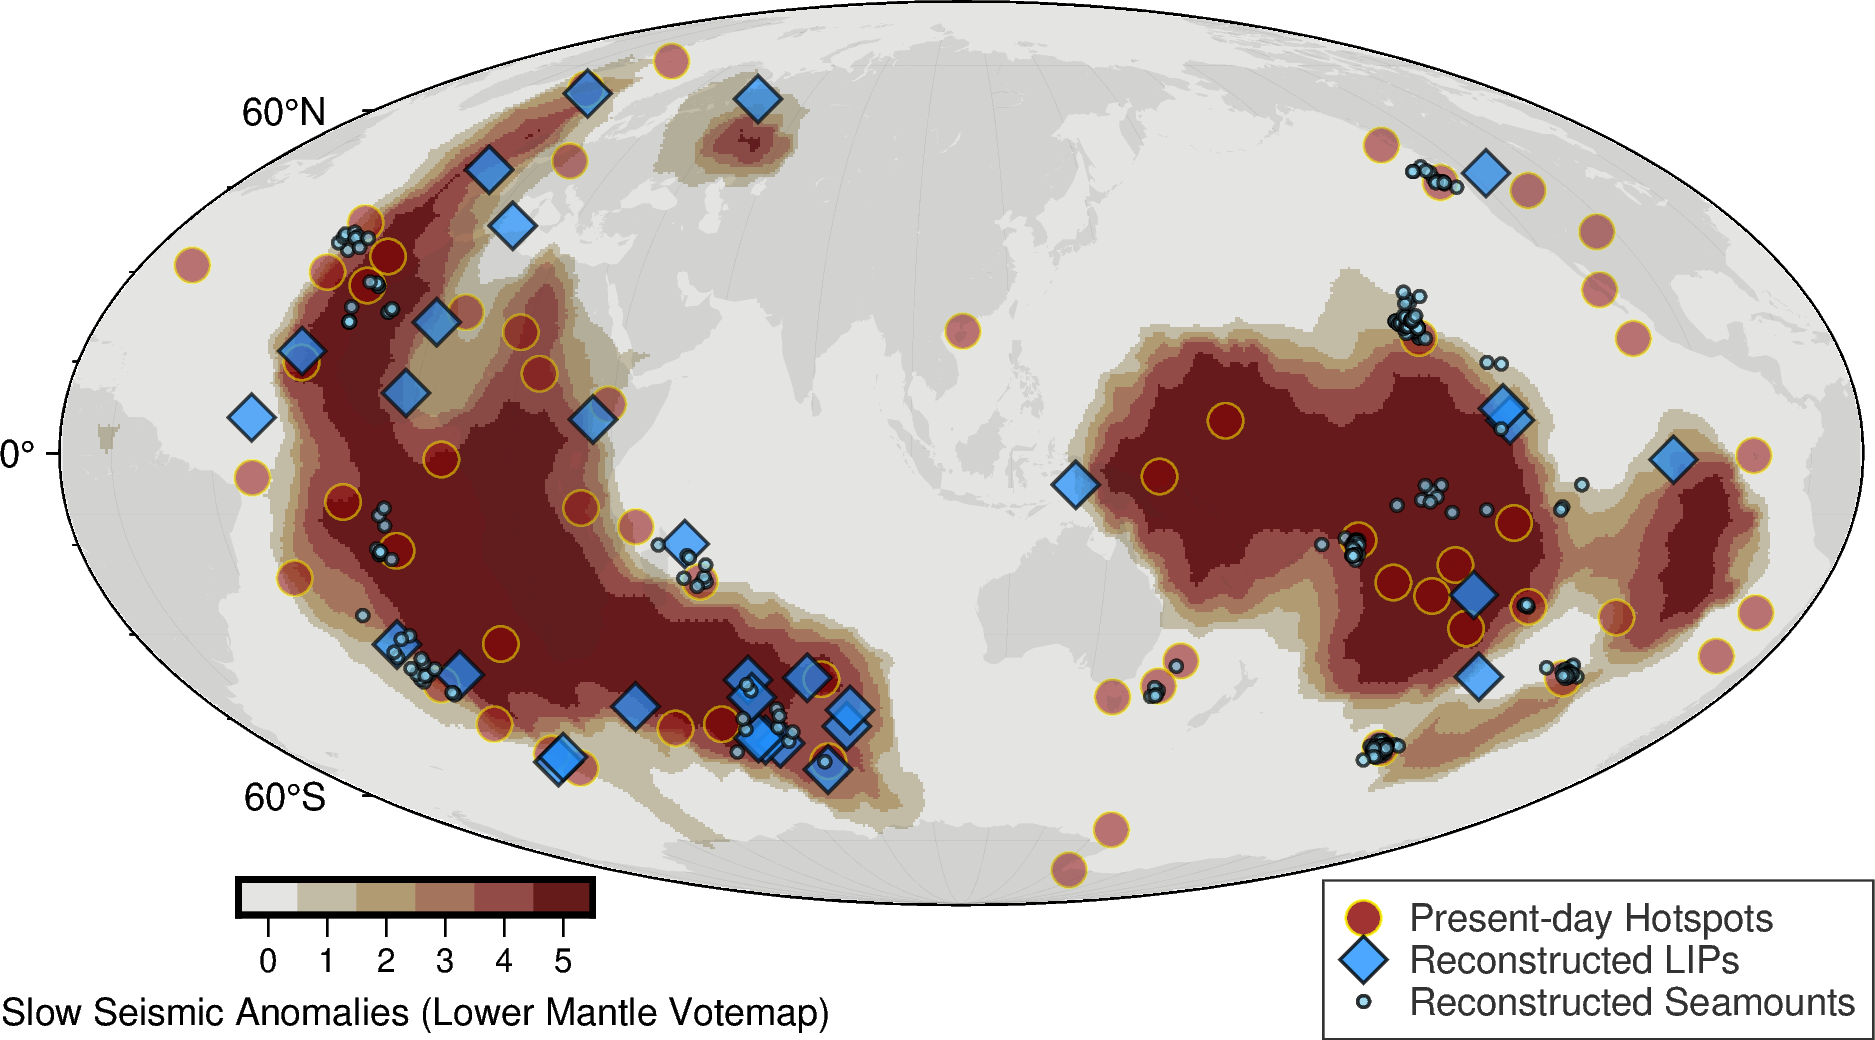

In [25]:
TC2017 = Reconstructions.fetch_TorsvikCocks2017()

LIP_centroids = pygplates.FeatureCollection('../data/CEED6_LIPCentersAround5Ma.gpml')
trails = gpd.read_file('../data/HotspotTrails.geojson')
trails = trails[trails.Chain.isin(['Hawaii','Louisville','Reunion','Tasmantid','Lord_Howe','Kerguelen',
                                   'Tristan','Canary','St_Helena','New_England','Tuamoto','Samoa',
                                   'Cobb','Foundation','Musicians','Marcus-Wake','Mid_Pacific_Mountains','Pitcairn','Shatsky'])]
trails = gdf2gpml(trails)


reconstruction_time = 180.

fig = pygmt.Figure()
fig.basemap(region='d', projection='W110/6i', frame='afg')

lekic_filt = pygmt.grdfilter(grid='../data/Clustering_Lekic.nc', distance=2, filter='g800', spacing='0.5d')
pygmt.makecpt(cmap='bilbao', series=[-0.5,5.5,1], background=False) #, color_model="+c" + ",".join(['0','1','2','3','4','5']))
fig.grdimage(grid=lekic_filt.astype(int), cmap=True, transparency=0, interpolation='l')

fig.plot(x=HS['Hotspot Longitude (at surface) Vertical plume'].astype(float),
         y=HS['Hotspot Latitude (at surface) Vertical plume'].astype(float), 
         style='c0.3c', pen='0.5p,yellow', color='darkred', transparency=50, label='Present-day Hotspots')

rLIPs = TC2017.reconstruct_to_time_of_appearance(LIP_centroids, ReconstructTime='MidTime')
rtrails = TC2017.reconstruct_to_time_of_appearance(trails)

fig.plot(data=gpml2gdf(rLIPs), style='d0.4c', pen='0.7p,black', color='dodgerblue', transparency=30, label='Reconstructed LIPs')

fig.plot(data=gpml2gdf(rtrails), style='c0.1c', pen='0.7p,black', color='skyblue', transparency=30, label='Reconstructed Seamounts')


fig.coast(land='gray20', transparency=90)
fig.legend(transparency=20, position='JBR+jBR+o-0.1c/-1.15c', box='+gwhite+p0.5p')
with pygmt.config(FONT_ANNOT_PRIMARY='8p', FONT_LABEL='9p'):
    fig.colorbar(position='JBL+jBL+o1.5c/-0.1c+w3c/0.3c+h', frame=['xa1+lSlow Seismic Anomalies (Lower Mantle Votemap)'])
#fig.coast(shorelines='gray20', transparency=60)

fig.savefig('./plume_generation_zone.pdf')
fig.show(width=1000)

